In [8]:
import numpy as np
from pycbc.waveform import get_td_waveform
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display
import threading

# Optimized default parameters for speed
default_params = {
    'mass1': 30,
    'mass2': 30,
    'spin1z': 0,
    'spin2z': 0,
    'distance': 1000,
    'inclination': 0,
    'delta_t': 1.0 / 1024,
    'f_lower': 30,
    'approximant': 'IMRPhenomXPHM'
}

_waveform_cache = {}
_update_timer = None

# Initialize figure with two traces: hp and hc
fig = go.FigureWidget()
fig.add_scatter(name=r'hp', line=dict(color='#39FF14'))  # neon green
fig.add_scatter(name=r'hc', line=dict(color='#FF6700'))  # neon orange

fig.update_layout(
    title='Gravitational Waveform',
    xaxis_title='Time (s)',
    yaxis_title='Strain',
    showlegend=True,
    xaxis=dict(range=[-1, 0.25]),
    yaxis=dict(range=[-1e-21, 1e-21]),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Sliders
slider_layout = widgets.Layout(width='250px', height='30px')

mass1_slider = widgets.FloatSlider(value=30, min=5, max=100, step=1, description='Mass 1')
mass2_slider = widgets.FloatSlider(value=30, min=5, max=100, step=1, description='Mass 2')
spin1x_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Spin 1x')
spin1y_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Spin 1y')
spin1z_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Spin 1z')
spin2x_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Spin 2x')
spin2y_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Spin 2y')
spin2z_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Spin 2z')
distance_slider = widgets.FloatSlider(value=1000, min=100, max=10000, step=100, description='Distance')
inclination_slider = widgets.FloatSlider(value=0, min=0, max=np.pi, step=0.1, description='Inclination')
coa_phase_slider = widgets.FloatSlider(value=0, min=0, max=2 * np.pi, step=0.1, description='Coa Phase')

def generate_waveform(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, dist, inc, coa_phase):
    key = (m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, dist, inc, coa_phase)
    if key in _waveform_cache:
        return _waveform_cache[key]
    hp, hc = get_td_waveform(
        mass1=m1,
        mass2=m2,
        spin1x=s1x,
        spin1y=s1y,
        spin1z=s1z,
        spin2x=s2x,
        spin2y=s2y,
        spin2z=s2z,
        distance=dist,
        inclination=inc,
        coa_phase=coa_phase,
        delta_t=default_params['delta_t'],
        f_lower=default_params['f_lower'],
        approximant=default_params['approximant']
    )
    result = (hp.sample_times.numpy(), hp.numpy(), hc.numpy())
    _waveform_cache[key] = result
    return result

def update_waveform():
    t, hp_wave, hc_wave = generate_waveform(
        mass1_slider.value,
        mass2_slider.value,
        spin1x_slider.value,
        spin1y_slider.value,
        spin1z_slider.value,
        spin2x_slider.value,
        spin2y_slider.value,
        spin2z_slider.value,
        distance_slider.value,
        inclination_slider.value,
        coa_phase_slider.value
    )
    with fig.batch_update():
        fig.data[0].x = t
        fig.data[0].y = hp_wave
        fig.data[1].x = t
        fig.data[1].y = hc_wave

def debounce_update(change=None):
    global _update_timer
    if _update_timer:
        _update_timer.cancel()
    _update_timer = threading.Timer(0.3, update_waveform)
    _update_timer.start()

# Link sliders with debounced update
sliders = [
    mass1_slider, mass2_slider,
    spin1x_slider, spin1y_slider, spin1z_slider,
    spin2x_slider, spin2y_slider, spin2z_slider,
    distance_slider, inclination_slider,
    coa_phase_slider
]
for slider in sliders:
    slider.observe(debounce_update, names='value')

# Initial plot
update_waveform()

# Organize sliders into rows
sliders_box = widgets.VBox([
    widgets.HBox([mass1_slider, mass2_slider], layout=widgets.Layout(justify_content='center')),
    widgets.HBox([spin1x_slider, spin1y_slider, spin1z_slider], layout=widgets.Layout(justify_content='center')),
    widgets.HBox([spin2x_slider, spin2y_slider, spin2z_slider], layout=widgets.Layout(justify_content='center')),
    widgets.HBox([distance_slider, inclination_slider, coa_phase_slider], layout=widgets.Layout(justify_content='center'))
], layout=widgets.Layout(align_items='center'))

final_layout = widgets.VBox([fig, sliders_box])
display(final_layout)


    'data': [{'line': {'color': '#39FF14'},
              'name': 'hp',
        …

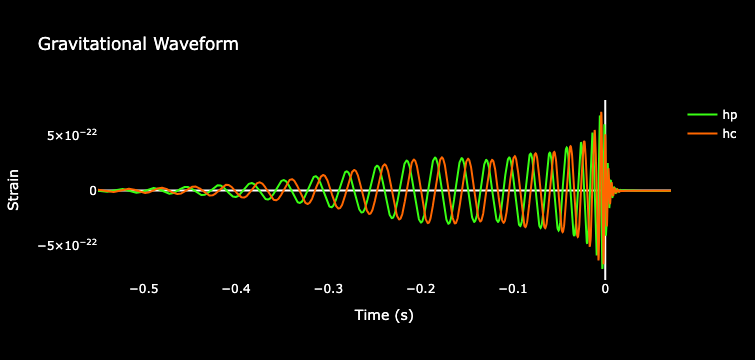

In [41]:
from IPython.display import Image, display

display(Image(filename='gw_vis.png'))